<a href="https://colab.research.google.com/github/dawg-at-irya/fit-line-MCMC/blob/main/fit_line_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Aim of this document: demonstrate MCMC line fitting for our previous dataset, then demonstrate it for data with intrinsic spread (a nuisance parameter).<br>

The $\texttt{emcee}$ package is described here:<br>
https://arxiv.org/abs/1202.3665<br>

I've used some code from the tutorials available here:<br>
https://emcee.readthedocs.io/en/stable/<br>


What are Markov Chains? What is Markov Chain Monte Carlo?<br>
https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2023/Handouts/MonteCarlo_LuisAguilar.pdf<br>
https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2023/Lectures/Lecture19.pdf<br>

### Let's start with some background.

We've fit a line to data in previous DAWGI sessions using frequentist methods, which involve working with the **likelihood** of the model given the data. This likelihood is a function of the model parameters alone, so we can optimise it to compute the best-fit values of the parameters given the data. As we have already seen, if the measurement noise is Gaussian, this **maximum likelihood estimation** is the same as **minimising the $\chi^2$**.<br>

Problems with this method mainly arise because of two issues: (a) computing the uncertainties and covariances between parameters can be difficult for the typical astronomical case and (b) **the interpretation of the frequentist confidence interval is not intuitive**.<br>

### Bayes' Theorem written for parameter inference

If we have data $\{\vec{x}, \vec{y}\}$ and a model with parameters $\vec{\theta}$, the **posterior distribution** of the parameters given the data is<br>
$p(\vec{\theta}|\{\vec{x}, \vec{y}\})\propto \mathscr{L}(\{\vec{x}, \vec{y}\}|\vec{\theta})\times \pi(\vec{\theta})$<br>
The first term on the right is the likelihood of the data given the model parameters, and the second term is the **prior probability** of the model parameters -- any knowledge of the distribution of their values that we had **before** the data was obtained.<br><br>
The resulting **joint posterior probability distribution** can be used to compute **marginal posteriors for individual parameters** and to compute **credible intervals** for each, and to visualise parameter covariances in a straightforward way.<br>
However, this requires us to generate samples from the posterior distribution. For typical problems, this is the main roadblock in implementing Bayesian methods. **A solution to this problem is the Markov Chain Monte Carlo technique, which allows us to generate samples from a given distribution**.<br>


For more:<br>
https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2023/Lectures/Lecture17.pdf<br>
https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2023/Lectures/Lecture18.pdf

### Choice of prior distribution

One of the extra requirements for Bayesian inference over frequentist inference is the specification of prior distributions for the parameters. There are many ways to specify priors, based on what kind of information you already have about them -- you can have empirical priors (based on some observational constraints on the parameters from past experiments) or non-informative/uninformative priors (simple constraints on the parameter values based on physical arguments).<br>

A typical non-informative prior is the **flat prior**, a uniform distribution within a range of values. Note that it is sometimes better to impose a flat prior **on the logarithm of a parameter rather than the parameter itself** -- for example, this can ensure that the parameter values are always positive (one example of such a case is the non-uniform prior for an unknown standard deviation).<br>

### Let's use the $\texttt{emcee}$ package to demonstrate the basic code blocks required to fit a line to data with Gaussian measurement noise.

##### Code to generate synthetic data (a) with only Gaussian measurement noise and (b) with Gaussian measurement noise and intrinsic spread.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def make_data(A_true, B_true, N_data=15, plot=True):
  """
    Simulate data from a straight-line model with uncertainties.
    Arguments:
      A_true, B_true: true value of intercept and slope
      N_data: number of data points to return
    Returns:
      x, y: independent and dependent variable values
      y_err: uncertainties in dependent variable
  """
  x = np.linspace(0, 10, 15)
  np.random.seed(1001) # for reproducibility
  y_err = norm.rvs(loc=0.35, scale=0.05, size=len(x))
  y = A_true + B_true * x + norm.rvs(scale=y_err)

  if plot:
    plt.errorbar(x, y, yerr=y_err, linestyle='none')
    plt.plot(x, y, 'ro', label='data')
    ylim = plt.ylim()
    plt.ylim(ylim[0] * 0.9, ylim[1] * 1.1)
    xlim = np.array(plt.xlim())
    plt.xlim(xlim[0] * 0.9, xlim[1] * 1.1)
    plt.plot(xlim, A_true + B_true * xlim, 'k-', label='True relation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='best')
    plt.show()

  return x, y, y_err

def make_data_intrinsic_spread(b_true=4.294, m_true=-0.9594, f_true=0.534,
                               N=50, plot=True):
  """
  Generate data from a model with intrinsic variance:
  y_mod = b_true + m_true * x
  y = y_mod + epsilon + f_true * y_mod
  epsilon is the Gaussian noise component
  f_true is the relative uncertainty intrinsic to the quantity y_mod
  """
  np.random.seed(123)

  # Generate some synthetic data from the model.
  N = 50
  x = np.sort(10 * np.random.rand(N))
  y_err = 0.1 + 0.5 * np.random.rand(N)
  y = m_true * x + b_true
  y += np.abs(f_true * y) * np.random.randn(N)
  y += y_err * np.random.randn(N)

  if plot:
    plt.errorbar(x, y, yerr=y_err, fmt=".r", capsize=0)
    x0 = np.linspace(0, 10, 500)
    plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
    plt.xlim(0, 10)
    plt.xlabel("x")
    plt.ylabel("y");

  return x, y, y_err

##### Let's generate some data with Gaussian noise

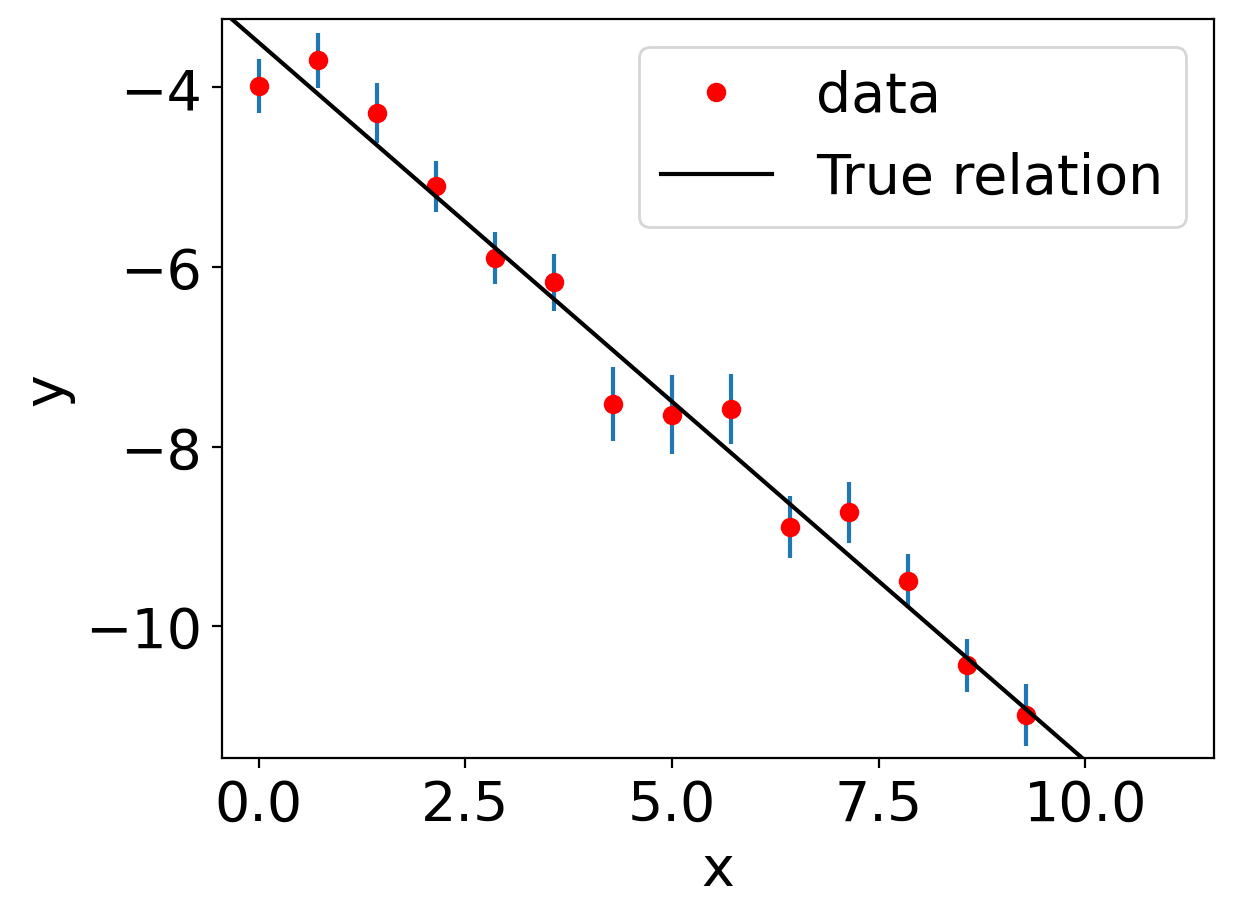

In [17]:
N_data=15
b_true, m_true = -3.5, -0.8
x, y, y_err = make_data(b_true, m_true, N_data=15)

##### Let's recompute the maximum likelihood estimate as we did in the previous DAWGI session

Least-squares estimates:
m = -0.801 ± 0.027
b = -3.467 ± 0.153
Maximum likelihood estimates:
m = -0.801
b = -3.467


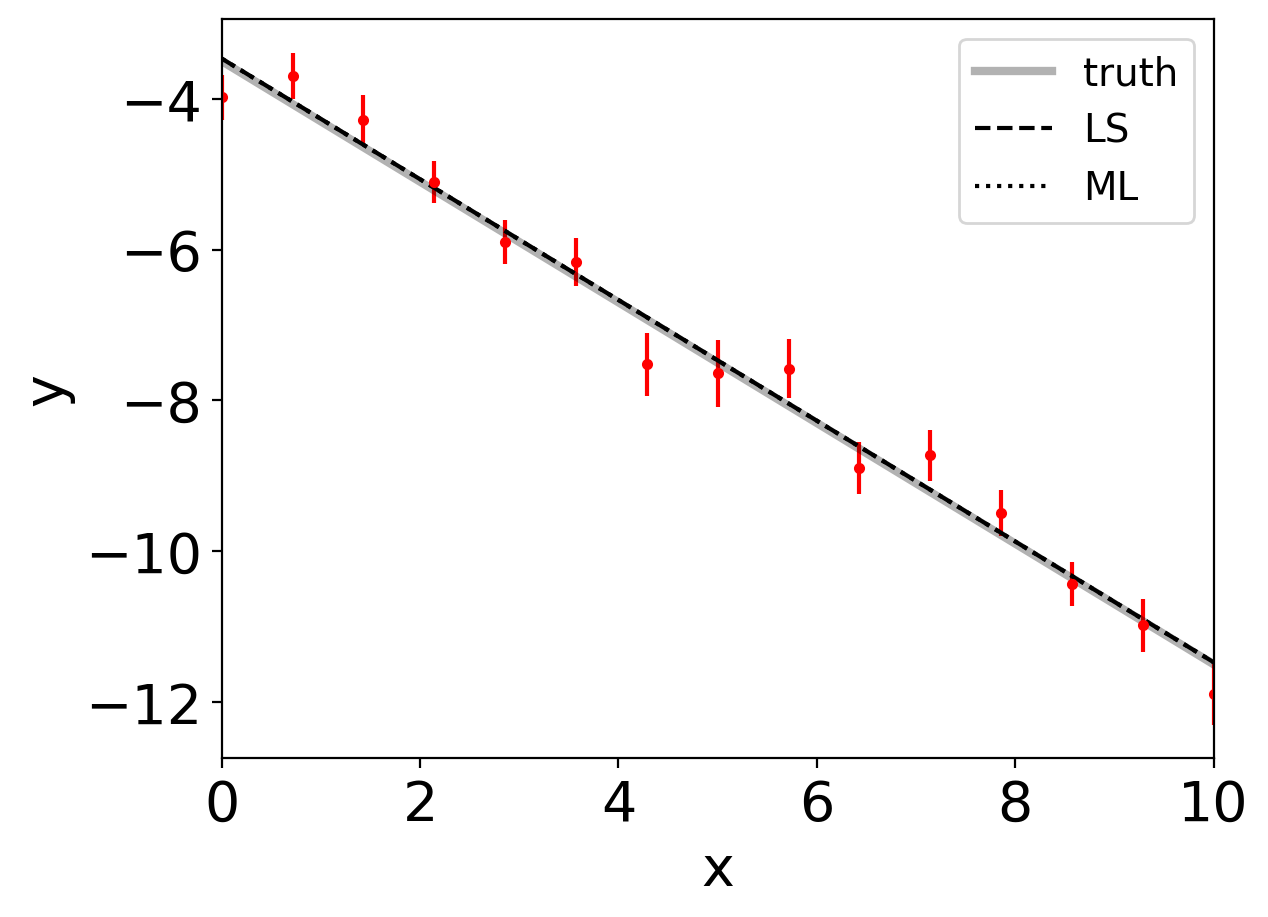

In [16]:
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


# The following is the exact solution using matrix algebra
A = np.vander(x, 2)
C = np.diag(y_err * y_err)
ATA = np.dot(A.T, A / (y_err**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / y_err**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

x0 = np.linspace(0, 10, 500)
# plt.errorbar(x, y, yerr=y_err, fmt=".k", capsize=0)
# plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
# plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
# plt.legend(fontsize=14)
# plt.xlim(0, 10)
# plt.xlabel("x")
# plt.ylabel("y")

# The following maximises the likelihood
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial, args=(x, y, y_err))
m_ml, b_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))

plt.errorbar(x, y, yerr=y_err, fmt=".r", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

##### In this case, the LS and ML methods are consistent with the truth.

### Let's solve the same problem with MCMC

In [5]:
!pip install emcee
import emcee
!pip install corner
import corner

In [6]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

##### Setting up the posterior probability calculation<br>

##### The log-likelihood block should look familiar. The log-prior block uses a uniform prior for both the slope and the intercept, such that the probability is constant if the parameter value is within the specified range. Outside this range, the probability is zero and therefore the log-probability is set to $\texttt{-np.inf}$.

##### The log-probability block then computes the log-posterior by summing the results from the first two blocks.

In [7]:
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b = theta
    if -5.0 < m < -2.0 and -2.0 < b < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

##### MCMC walkers are initialised in a tiny Gaussian ball around the ML result.

##### $\texttt{emcee}$ uses an **ensemble sampler**, which means it initialises multiple **walkers**, each of which is a Markov chain that explores the parameter space.

In [8]:
soln.x

array([-0.80067327, -3.46651826])

In [9]:
pos = soln.x + 1e-3 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, y_err)
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:09<00:00, 506.95it/s]


##### We'll explain the following steps in more detail when we consider the more complicated case of intrinsic spread

In [10]:
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [11]:
flat_samples.shape

(10432, 2)

##### Let's visualise the resulting posterior distribution by generating 100 samples from it (seen in the plot in orange)

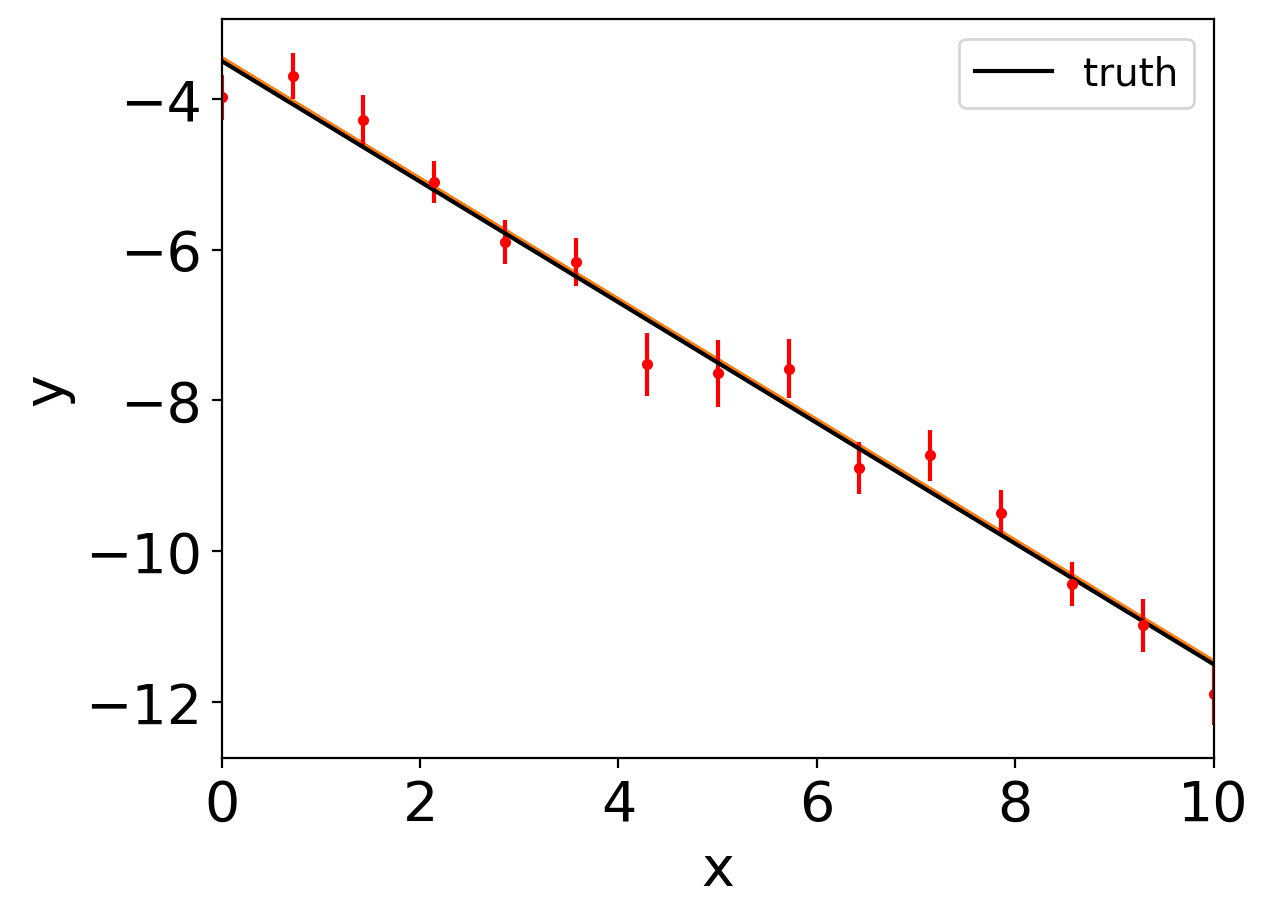

In [12]:
labels = ["m", "b"]

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=y_err, fmt=".r", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

###Fitting a line to data with intrinsic spread<br>

##### To get a more detailed idea, let's fit a more complicated dataset: one with intrinsic spread. With the additional parameter for the standard deviation of the intrinsic spread, there are now three parameters -- we are interested in the slope and the intercept.

##### The intrinsic spread can be treated as a **nuisance parameter**, one that is essential for inference but isn't necessary to interpret the results. We will use it to compute the joint posterior, but will integrate it out (**marginalise over it**) to get the posterior distributions of the slope and intercept.

##### In this case, while the model is still linear:<br>
$y_{{\rm mod}, i} = b_{\rm true} + m_{\rm true} x_i$,<br><br>

The quantity $y$ has intrinsic spread due to some specific physics. This is in addition to the Gaussian measurement noise; that is,<br>
$y_{{\rm obs}, i} = y_{{\rm mod}, i} + \epsilon_{{\rm meas}, i} + f_{\rm true} y_{{\rm mod}, i}\epsilon_{{\rm int}, i}$,<br>
so that while $\mathbb{E}[y_{\rm obs, i}] = y_{\rm mod, i}$ as before, ${\rm Var}[y_{\rm mod, i}] = \sigma_{\rm meas}^2 + f_{\rm true}^2\sigma_{{\rm int}, i}$,<br>
with $\sigma_{\rm meas}$ and $\sigma_{\rm int}$ the standard deviations of the Gaussian measurement noise and the intrinsic spread respectively.

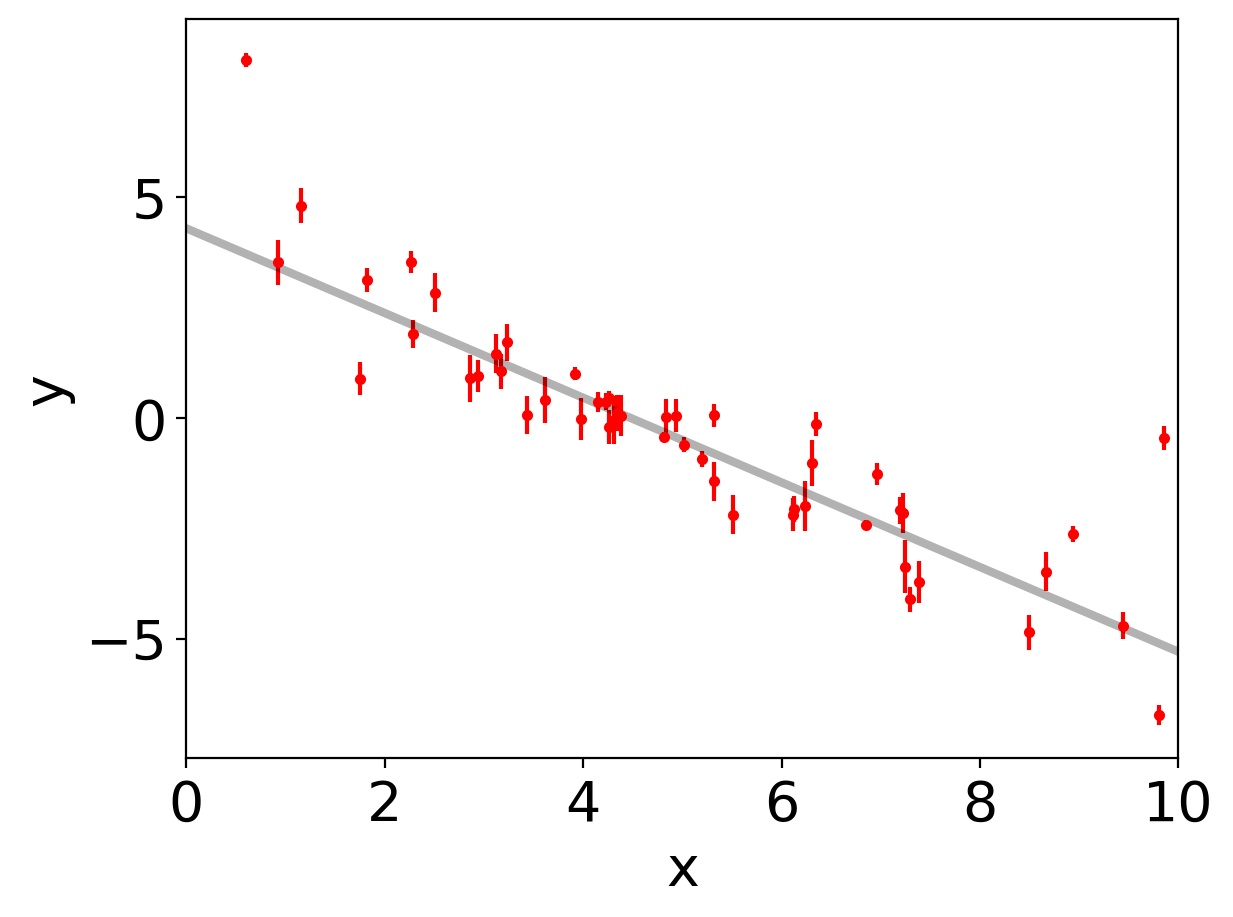

In [21]:
N_data=50
# b_true, m_true, f_true = -3.5, -0.8, 0.534
b_true, m_true, f_true=4.294, -0.9594, 0.534
x, y, y_err = make_data_intrinsic_spread(b_true, m_true, f_true, N=N_data)

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091
Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


Text(0, 0.5, 'y')

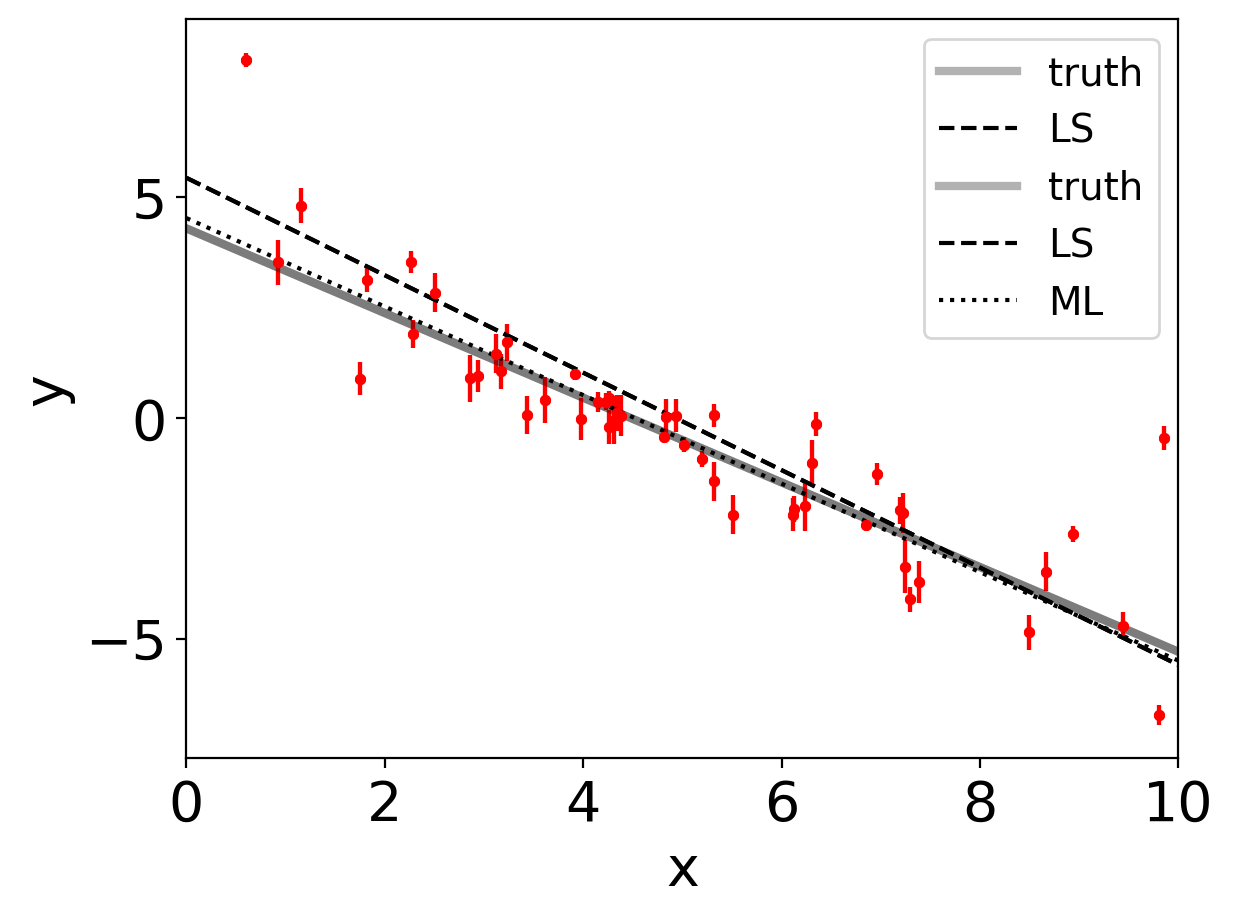

In [24]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

# Matrix algebra for exact solution to problem without intrinsic errors
A = np.vander(x, 2)
C = np.diag(y_err * y_err)
ATA = np.dot(A.T, A / (y_err**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / y_err**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=y_err, fmt=".r", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

# ML estimate
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, y_err))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=y_err, fmt=".r", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")



#### For this problem, the ML estimate is much closer to the truth. The matrix algebra solution doesn't take intrinsic variance into account, so it fails to generate realistic estimates and uncertainties! This is a common problem when fitting such data.

### Now, the MCMC way

Initialise the walkers

In [28]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, y_err)
)
sampler.run_mcmc(pos, 5000, progress=True);

samples = sampler.get_chain()

100%|██████████| 5000/5000 [00:09<00:00, 514.31it/s]


##### Let us inspect the sampler results.

#### As a first step, we inspect the time series of the parameters in the chain.

##### The samples can be accessed using the $\texttt{EnsembleSampler.get_chain()}$ method. This will return an array with the shape $\texttt{(5000, 32, 2)}$ giving the parameter values for each walker at each step in the chain. The figure below shows the positions of each walker as a function of the number of steps in the chain.

In [29]:
samples.shape

(5000, 32, 3)

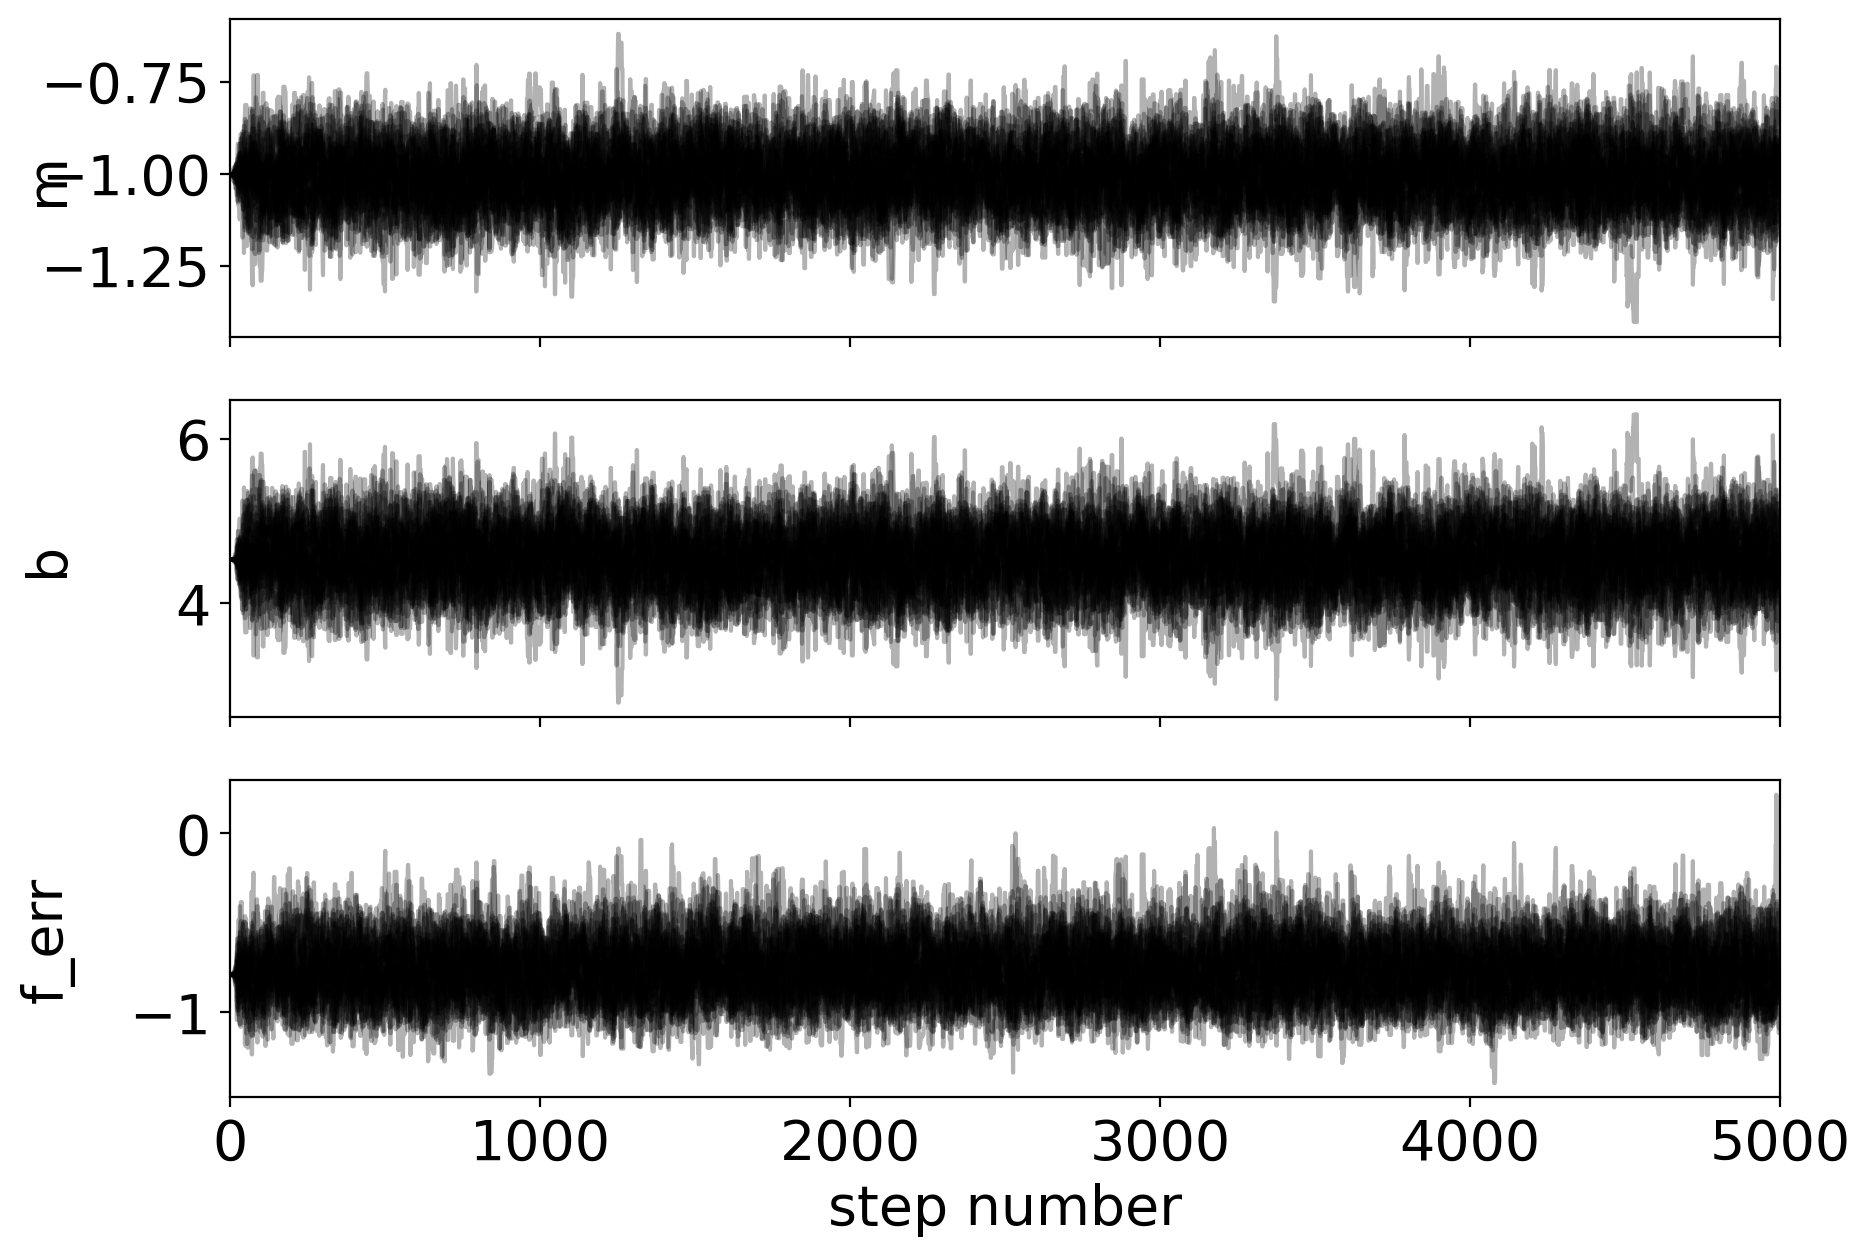

In [32]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ["m", "b", "f_err"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

###Integrated autocorrelation time

#####If samples are independent, then uncertainty $\sim \displaystyle{1\over\sqrt{N}}$.

However, Markov Chain samples are correlated! Uncertainty $\sim \displaystyle{\tau_f\over\sqrt{N}} > \displaystyle{1\over\sqrt{N}}$, where $\tau_f$ is the integrated autocorrelation time.

It can be thought as the number of steps taken for the chain to forget its initial state.

The autocorrelation time can be estimated using samples from the Markov Chain; however, enough samples are needed for accurate estimates of this quantity. The parallelisation of chains in the $\texttt{emcee}$ package means that convergence can be expected for chains longer than $\approx 50\tau$. In other words, **do not trust your estimate for $\tau_f$ if the number of samples in the chain used to estimate $\tau_f$ are less than $50\tau_f$**.

In [33]:
tau = sampler.get_autocorr_time()
print(f"Autocorrelation time estimated in three ways: {tau}")
samples = sampler.get_chain()
if samples.shape[0] < tau[0] * 50:
  print("Caution: Number of samples in chain fewer than 50 times the autocorrelation time!")
else:
  print("Number of samples in chain adequate for autocorrelation time estimate!")

Autocorrelation time estimated in three ways: [33.47736548 33.4716946  38.89948359]
Number of samples in chain adequate for autocorrelation time estimate!


To be safe, we will discard the first 3 * tau sxteps as burn-in.

We will then thin by half the autocorrelation time (i.e., we will only select every 15th sample).

Finally, we will flatten the chain to obtain a flat list of samples.

In [34]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


In [35]:
!pip install corner

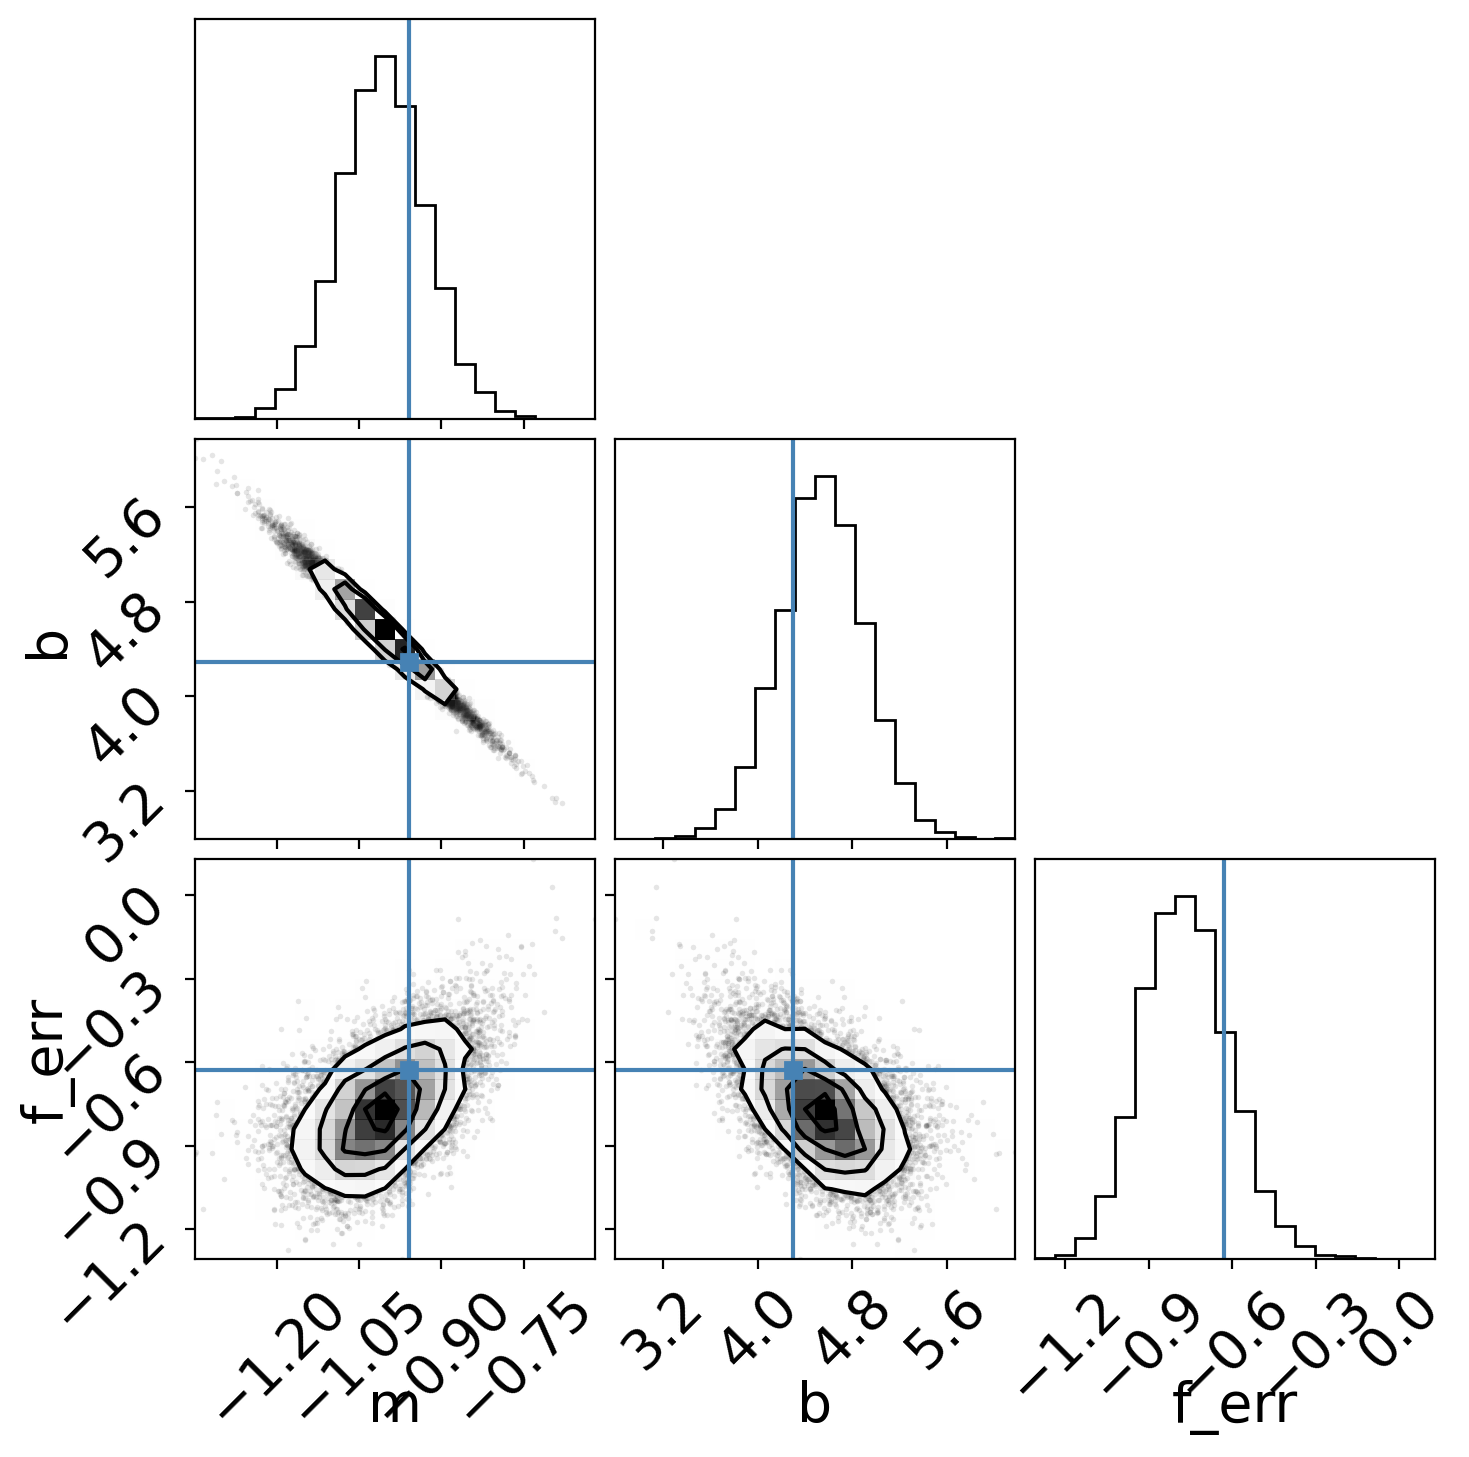

In [36]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

Note that the MAP values of the parameters do not coincide with their true values. This is one reason that we need to provide credible intervals!

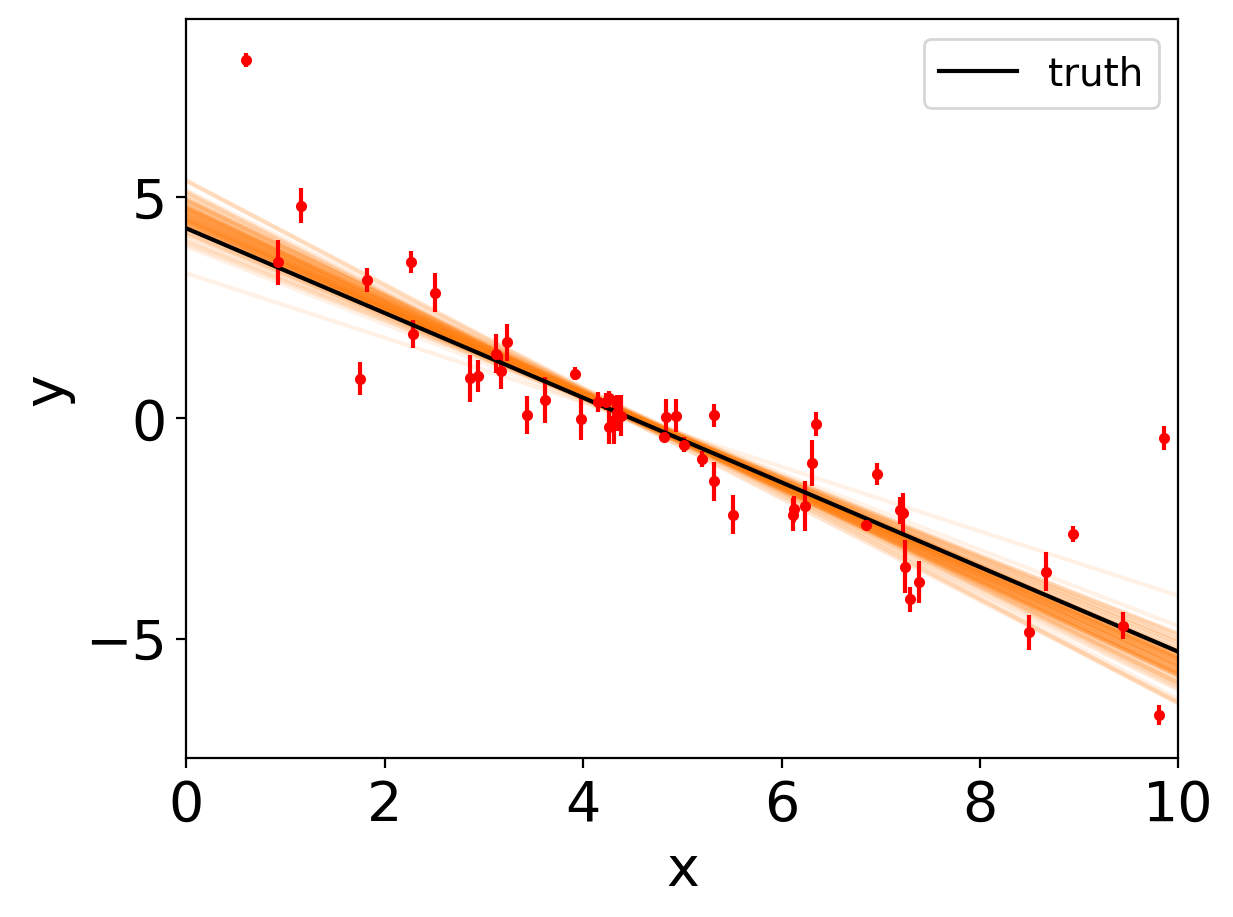

In [39]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=y_err, fmt=".r", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Let's print out the median and the 68% credible interval for each parameter.

In [40]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>